# Feature Remove

4가지 방법에서 계산한 특성 중요도를 기반으로, 상위 8개의 특성을 제거 후 성능 측정

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle, resample

from xgboost import XGBClassifier
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [27]:
def make_train_dataset(X_train, seed):
    # upsampling abnormal data
    X_train_normal = X_train[X_train.Class==0]
    X_train_abnormal = X_train[X_train.Class==1]
    
    X_abnormal_res = resample(X_train_abnormal, replace=True, n_samples=X_train_normal.shape[0], random_state=seed)
    X_train = pd.concat([X_train_normal, X_abnormal_res])
    
    y_train = X_train.Class
    X_train = X_train.drop('Class', axis=1)
    
    # shuffle 
    X_res, y_res = shuffle(X_train, y_train, random_state=seed)
    
    return X_res, y_res

In [28]:
# 사전 계산된 특성 중요도 상위 8개
gain_feature_top = ['V14', 'V4', 'V12', 'V8', 'V20', 'Amount', 'V10', 'V7']
cover_feature_top = ['V14', 'V4', 'V10', 'V12', 'V11', 'V20', 'V7', 'V1']
weight_feature_top = ['V14', 'V4', 'V12', 'V26', 'Amount', 'V10', 'V11', 'V7']
shap_feature_top = ['V14', 'V4', 'V12', 'V11', 'V3', 'V3', 'V10', 'Amount']

tops = 8

assert len(gain_feature_top) == tops
assert len(cover_feature_top) == tops
assert len(weight_feature_top) == tops
assert len(shap_feature_top) == tops

In [29]:
result = {'Gain': [],
          'Cover': [],
          'Weight': [],
          'Shap': []}

# repeat: n_iter(50)
for seed in tqdm(range(50)):
    data = pd.read_csv('./creditcard.csv')
    data.drop('Time', axis=1, inplace=True)
    X_train, X_test = train_test_split(data, stratify=data.Class, test_size=0.25, random_state=seed)
    
    ss = StandardScaler()
    X_train['Amount'] = ss.fit_transform(X_train['Amount'].values.reshape(-1, 1))
    X_test['Amount'] = ss.transform(X_test['Amount'].values.reshape(-1, 1))
    
    y_test = X_test.Class
    X_test = X_test.drop('Class', axis=1)
    
    # upsampling
    X_res, y_res = make_train_dataset(X_train, seed)
    
    # feature selection 
    gain_cols = [col for col in X_res.columns if col not in gain_feature_top]
    cover_cols = [col for col in X_res.columns if col not in cover_feature_top]
    weight_cols = [col for col in X_res.columns if col not in weight_feature_top]
    shap_cols = [col for col in X_res.columns if col not in shap_feature_top]
    
    X_res_gain = X_res[gain_cols]
    X_res_cover = X_res[cover_cols]
    X_res_weight = X_res[weight_cols]
    X_res_shap = X_res[shap_cols]
    
    # default hyperparameters 
    xgb_gain = XGBClassifier(seed=seed)
    xgb_cover = XGBClassifier(seed=seed)
    xgb_weight = XGBClassifier(seed=seed)
    xgb_shap = XGBClassifier(seed=seed)
    
    xgb_gain.fit(X_res_gain, y_res)
    xgb_cover.fit(X_res_cover, y_res)
    xgb_weight.fit(X_res_weight, y_res)
    xgb_shap.fit(X_res_shap, y_res)

    result['Gain'].append(f1_score(y_test, xgb_gain.predict(X_test[gain_cols])))
    result['Cover'].append(f1_score(y_test, xgb_cover.predict(X_test[cover_cols])))
    result['Weight'].append(f1_score(y_test, xgb_weight.predict(X_test[weight_cols])))
    result['Shap'].append(f1_score(y_test, xgb_shap.predict(X_test[shap_cols])))

100%|██████████| 50/50 [08:44<00:00, 10.49s/it]


In [34]:
xgb_top_remove_df = pd.DataFrame(result)
xgb_top_remove_df

,Gain,Cover,Weight,Shap
0,0.826667,0.830357,0.824561,0.826087
1,0.862903,0.853659,0.854839,0.854772
2,0.853556,0.855967,0.841667,0.828452
3,0.858333,0.860759,0.857143,0.871795
4,0.846154,0.849785,0.825532,0.838983
5,0.841629,0.853333,0.844444,0.839286
6,0.808696,0.822034,0.818565,0.803347
7,0.842105,0.832618,0.834783,0.818966
8,0.858333,0.843882,0.841667,0.835443
9,0.867257,0.863436,0.872247,0.852174


In [35]:
xgb_top_remove_df.mean()

Gain      0.836075
Cover     0.839702
Weight    0.830160
Shap      0.826872
dtype: float64

In [37]:
xgb_top_remove_df.std()

Gain      0.019378
Cover     0.020833
Weight    0.020679
Shap      0.019697
dtype: float64

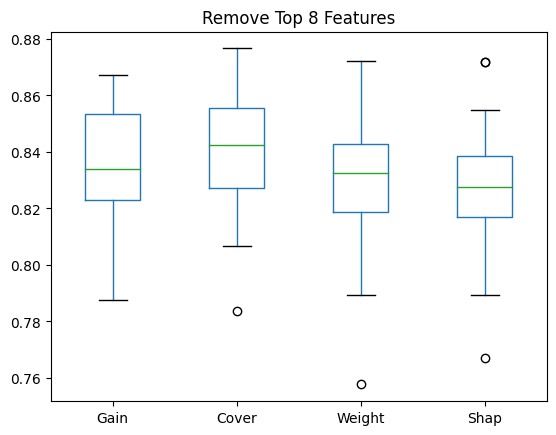

In [40]:
xgb_top_remove_df.boxplot(grid=False)
plt.title('Remove Top ' + str(tops) + ' Features')
plt.show()

In [41]:
xgb_top_remove_df.to_csv('xgb_remove_top8.csv')